# Data exploration and pre-processing

## Data reading 

In [1]:
import re
import pandas as pd
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv("../processed_tweet_data.csv")
tweets[:2]

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,False,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,False,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       6532 non-null   int64  
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  3618 non-null   object 
 12  hashtags            6532 non-null   object 
 13  user_mentions       6532 non-null   object 
 14  place               4088 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 765.6+

In [4]:
print("The number of missing value(s): {}".format(tweets.isnull().sum().sum()))
print("Columons having columns value: {}".format(tweets.columns[tweets.isnull().any()]))

The number of missing value(s): 5358
Columons having columns value: Index(['possibly_sensitive', 'place'], dtype='object')


## Pre-processing

In [5]:
sys.path.append(os.path.abspath(os.path.join('..')))

from clean_tweets_dataframe import Clean_Tweets

In [6]:
ct = Clean_Tweets(tweets)

Automation in Action...!!!


### Drop unwanted columns

In [7]:
print(f"Shape of tweets before droping unwanted tweets {tweets.shape}")
tweets = ct.drop_unwanted_column(tweets)
print(f"Shape of tweets after droping unwanted tweets {tweets.shape}")

Shape of tweets before droping unwanted tweets (6532, 15)
Shape of tweets after droping unwanted tweets (6532, 15)


this indicates all values of retweet_count column are valid bc no row was dropped

### Drop duplicate

In [8]:
print(f"Shape of tweets before droping duplicates tweets {tweets.shape}")
ct.drop_duplicate(tweets)
print(f"Shape of tweets after droping duplicates tweets {tweets.shape}")

Shape of tweets before droping duplicates tweets (6532, 15)
Shape of tweets after droping duplicates tweets (6532, 15)


this indicates there aren't duplicate values in the data

### Convert Created time to date time

In [9]:
print(f"The first row created time before conversion {tweets.created_at[0]}")
tweets = ct.convert_to_datetime(tweets)
print(f"The first row created time after conversion {tweets.created_at[0]}")

The first row created time before conversion Fri Jun 18 17:55:49 +0000 2021
The first row created time after conversion 2021-06-18 17:55:49+00:00


### Convert numeric values to number

In [10]:
tweets = ct.convert_to_numbers(tweets)

### Remove non english tweets


In [11]:
print(f"Shape of tweets before removing non english tweets {tweets.shape}")
tweets = ct.remove_non_english_tweets(tweets)
print(f"Shape of tweets after removing non english tweets {tweets.shape}")

Shape of tweets before removing non english tweets (6532, 17)
Shape of tweets after removing non english tweets (6532, 17)


### Removing Punctuations, Numbers, and Special Characters

In [12]:
tweets['original_text'] = tweets['original_text'].str.replace("[^a-zA-Z#]", " ")
tweets['original_text'][:3]

0     Africa is  in the midst of a full blown third...
1    Dr Moeti is head of WHO in Africa  and one of ...
2    Thank you  research note for creating this ama...
Name: original_text, dtype: object

### Remove links

In [13]:
tweets['original_text'] = tweets.original_text.replace( r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
tweets['original_text'][:3]

0     Africa is  in the midst of a full blown third...
1    Dr Moeti is head of WHO in Africa  and one of ...
2    Thank you  research note for creating this ama...
Name: original_text, dtype: object

### Save cleaned data

In [14]:
tweets.to_csv(r'clean_tweets.csv')

## Data exploration 

### Rows and columns in the dataset

In [15]:
tweets = pd.read_csv("clean_tweets.csv")

In [16]:
print('Count of columns in the data is:  ', len(tweets.columns))
print('Count of rows in the data is:  ', len(tweets))

Count of columns in the data is:   18
Count of rows in the data is:   6532


### Users that made the tweets

In [17]:
tweets.groupby("original_author").size().agg( ['count', 'min', 'max', 'mean', 'median'])

count     5248.000000
min          1.000000
max        530.000000
mean         1.244665
median       1.000000
dtype: float64

From this we can observe the tweets were made by 5248. Most of them had made the tweet once and 
the person with the most tweet had made 530 tweets.

In [18]:
twetter_users = tweets.groupby("original_author").size()
twetter_users.nlargest(5)

original_author
PuneUpdater        530
viralvideovlogs     45
Signal__Pump        27
WHO__India          27
Rosenchild          11
dtype: int64

This indicates the person who made 530 tweets is an outlier.

### Tweet sentiments

In [19]:
def text_category(p):
  if p > 0:
    return "positive"
  elif p < 0:
    return "negative"
  else:
    return "neutral" 

In [20]:
tweets["score"] = tweets["polarity"].apply(text_category)
tweets.groupby("score")["polarity"].count()


score
negative    1277
neutral     1829
positive    3426
Name: polarity, dtype: int64

In [21]:
tweet_sent = tweets.groupby(['score']).sum(
)[["favorite_count", "followers_count", "friends_count"]]
tweet_sent

,favorite_count,followers_count,friends_count
score,,,
negative,159704,10157572,1278012
neutral,396722,36775025,2520950
positive,1030171,60839857,7355421


We can observe positive tweets are more liked, people whith more followers and freands had made a positive tweet obout covid19.

### Hashtags

In [22]:
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', str(tweet))

In [23]:
tweets['hashtags'] = tweets.original_text.apply(find_hashtags)
print(tweets['hashtags'])


0                      []
1                      []
2                  [#red]
3                [#Covid]
4                      []
              ...        
6527                   []
6528             [#Covid]
6529                   []
6530    [#COVID, #Africa]
6531                   []
Name: hashtags, Length: 6532, dtype: object


In [24]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = tweets.loc[
    tweets.hashtags.apply(
        lambda hashtags_list: hashtags_list != []
    ), ['hashtags']]
hashtags_list_df[:5]

,hashtags
2,[#red]
3,[#Covid]
5,"[#WeCanDoThis, #COVID]"
9,"[#Covid, #DeltaVariant]"
10,"[#WeCanDoThis, #COVID]"


In [25]:
#create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
     for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df[:5]

,hashtag
0,#red
1,#Covid
2,#WeCanDoThis
3,#COVID
4,#Covid


In [26]:
fhd = flattened_hashtags_df.groupby("hashtag").size()
fhd.nlargest(5)

hashtag
#COVID          2659
#Covid           317
#Africa          180
#vaccines        177
#coronavirus     162
dtype: int64

## Visualisations

### Users that made the tweets


<AxesSubplot:title={'center':'Original source'}>

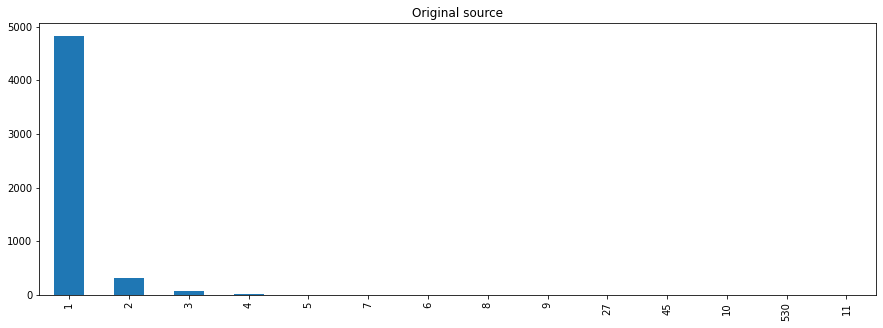

In [27]:
twetter_users.value_counts()[:20].plot(
    kind='bar', title='Original source', figsize=(15, 5))


This indicates most tweets are made by unique individuals.

### Tweet sentiments

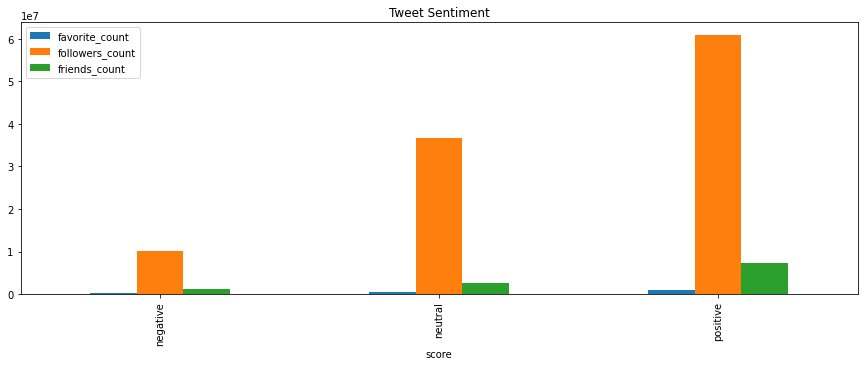

In [28]:
ax = tweet_sent.plot(
    kind='bar', title='Tweet Sentiment', figsize=(15, 5))


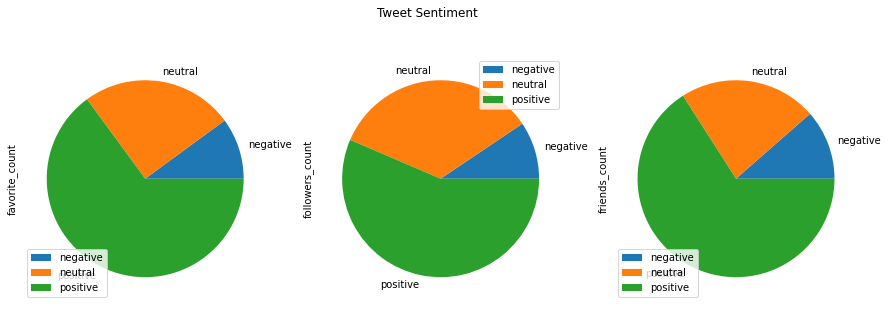

In [29]:
ax = tweet_sent.plot(
    kind='pie', title='Tweet Sentiment', subplots=True, figsize=(15, 5))


### Hashtags

<AxesSubplot:title={'center':'Hashtags in tweet'}, xlabel='hashtag'>

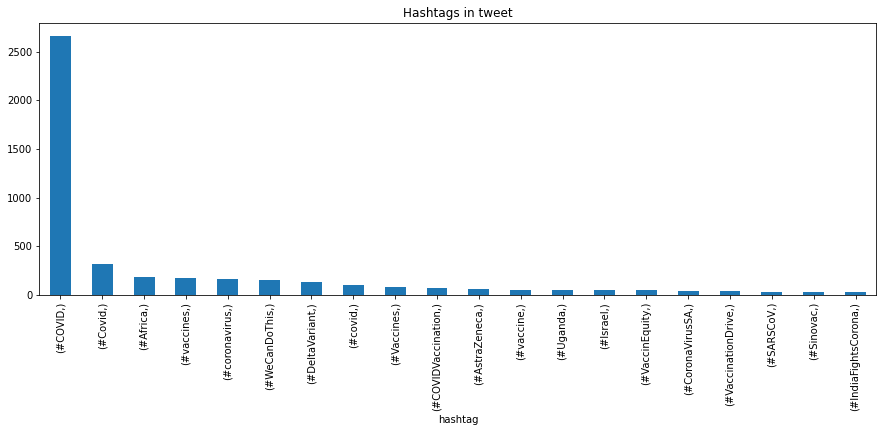

In [30]:
flattened_hashtags_df.value_counts()[:20].plot(
    kind='bar', title='Hashtags in tweet', figsize=(15, 5))


### words cloud for positive tweets

In [31]:
tweets['clean_text'] = tweets['original_text'].astype(str)
tweets['clean_text'] = tweets['clean_text'].apply( lambda x: x.lower())
positive_tweets = tweets[tweets['score'] == 'positive']

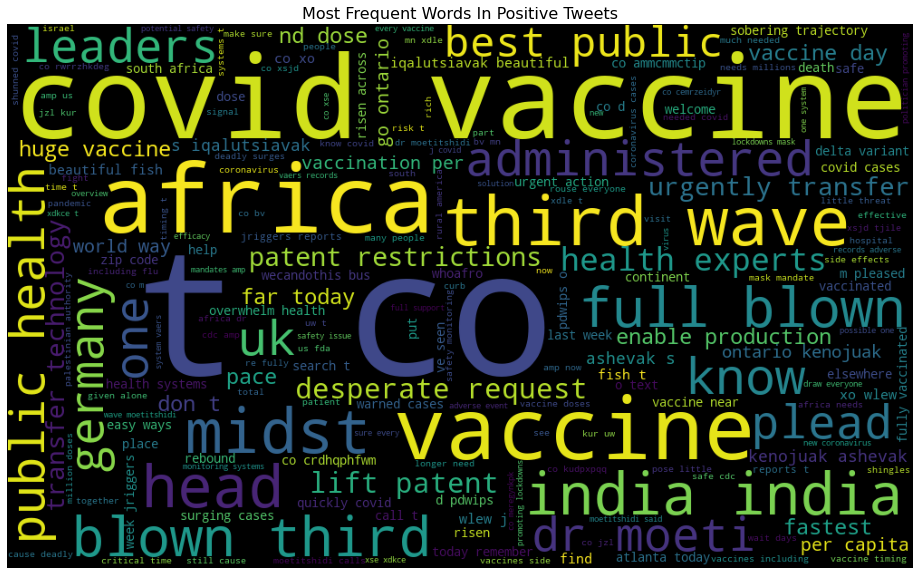

In [32]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000, height=600, stopwords=STOPWORDS).generate(
    ' '.join(positive_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Positive Tweets', fontsize=16)
plt.show()


### words cloud for negative tweets

In [33]:
negative_tweets = tweets[tweets['score'] == 'negative']

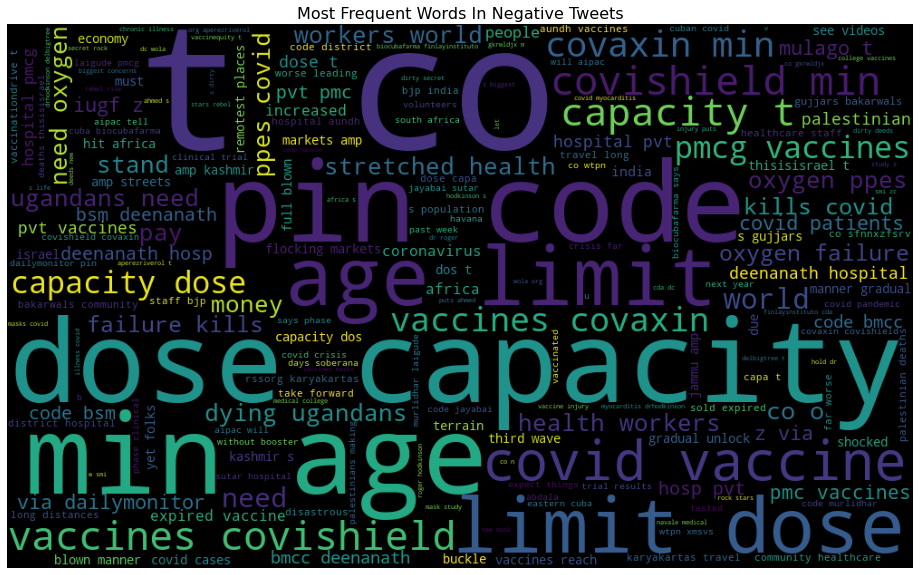

In [34]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000, height=600, stopwords=STOPWORDS).generate(
    ' '.join(negative_tweets.clean_text.values)))
plt.axis('off')
plt.title('Most Frequent Words In Negative Tweets', fontsize=16)
plt.show()


### words cloud for neutral tweets

In [35]:
neutral_tweets = tweets[tweets['score'] == 'neutral']

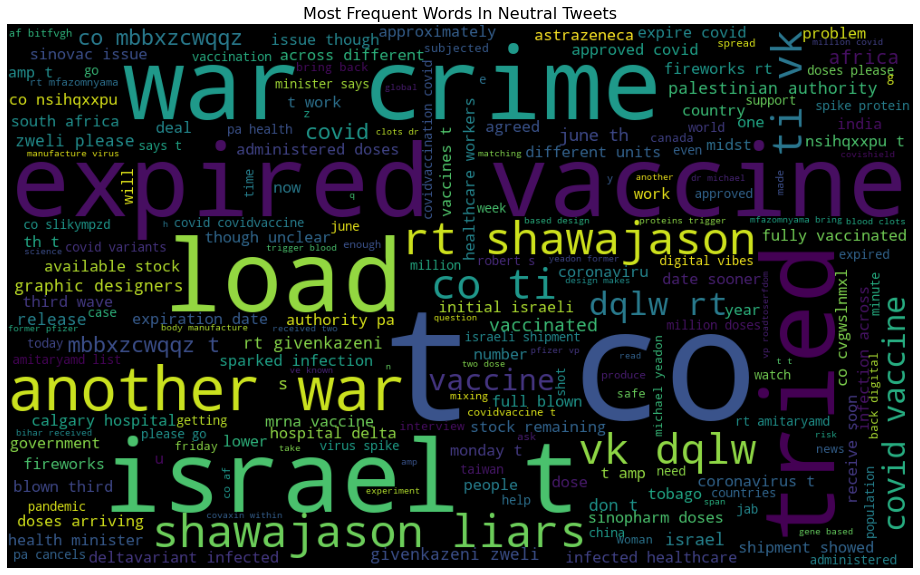

In [36]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000, height=600, stopwords=STOPWORDS).generate(
    ' '.join(neutral_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Neutral Tweets', fontsize=16)
plt.show()


### Word Cloud for all tweets

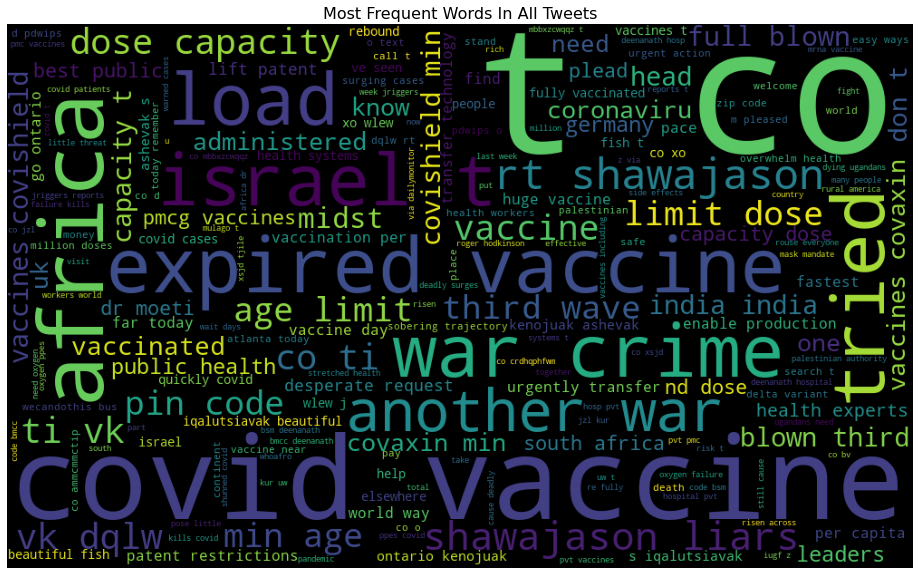

In [37]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000, height=600, stopwords=STOPWORDS).generate(
    ' '.join(tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In All Tweets', fontsize=16)
plt.show()
